# Exploratory Data Analysis

This notebook contains code for exploring the data, conducting PCA, and creating social networks. 

In [1]:
# Import Packages
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set_theme(style="darkgrid")


In [2]:
# Read in data
interactions_agg_long = pd.read_csv('data/processed/interactions_agg_long.csv', sep=',')
knn_dataset = pd.read_csv('data/processed/knn_dataset.csv', sep=',')
neural_network_dataset = pd.read_csv('data/processed/neural_network_dataset.csv', sep=',')

To start, I will investigate the spread of Topic consumption. 

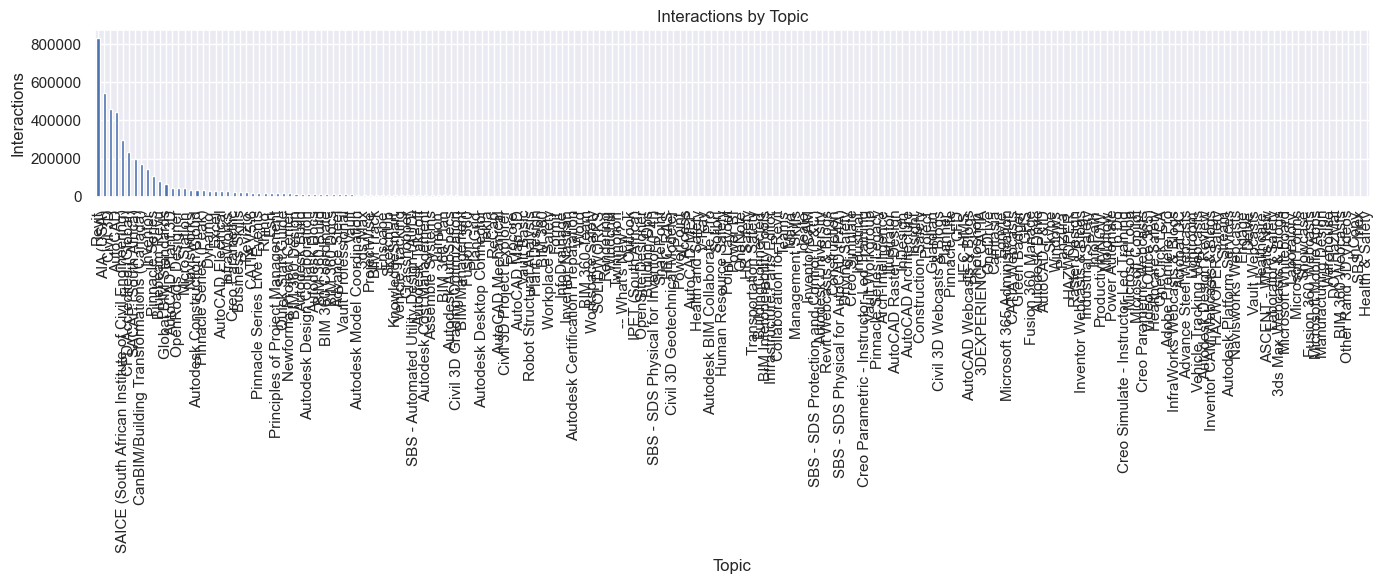

In [3]:
# Bar chart of Interactions by Topic
fig, ax = plt.subplots(figsize=(14, 6))
topic_data = interactions_agg_long.groupby('TOPIC')['INTERACTION_ID'].nunique().sort_values(ascending=False)
topic_data.plot(kind='bar', ax=ax)
ax.set_xlabel('Topic')
ax.set_ylabel('Interactions')
ax.set_title('Interactions by Topic')
plt.tight_layout()
plt.show()

There are way too many Topics to make sense of the data. This will be a problem to the EDA, social network, and potentially for the model training. I will export a listing of the topics and group each into a category, to reduce the number of total topics. 

In [4]:
# Get unique topics and convert to DF
unique_topics = interactions_agg_long['TOPIC'].unique()
unique_topics_df = pd.DataFrame(unique_topics, columns=['TOPIC'])

# Export
export_path = 'data/raw/' 
unique_topics_df.to_csv(f'{export_path}unique_topics.csv', index=False)

From here I uploaded the file into Claude and asked it to create a CSV with groupings for each topic. I was very specific to not make them too granular, but to also assist in not having such a broad list of Topics.

In [5]:
# Read in grouped Topics
unique_topics_grouped = pd.read_csv('data/processed/unique_topics_grouped.csv', sep=',')

In [6]:
# Left Join new grouped Topics
interactions_agg_long = interactions_agg_long.merge(
    unique_topics_grouped, 
    on='TOPIC', 
    how='left'
)
print(interactions_agg_long.head(1))

                         INTERACTION_ID INTERACTION_DATE   INTERACTION_TYPE  \
0  6B69E516-4178-49C2-A8A5-79EBDD03ABE9       2025-09-27  Course Enrollment   

                              TENANT_ID                               USER_ID  \
0  77737E65-0122-4E4B-8BED-1C901DC8CCC7  9E0518A2-1793-41DB-BB8A-06D5A20F60DA   

                             CONTENT_ID         INDUSTRY  SEGMENT      TOPIC  \
0  470EAED5-98EC-4131-8B00-562D7CBCEF27  Building Design  Midsize  AIA (USA)   

   TOPIC_SUBTOPIC                                 CATEGORY  
0  AIA (USA) 2024  Professional Certifications & Standards  


Now that the categorized topics have been created and joined back in, we can try looking at the interactions by topic again.

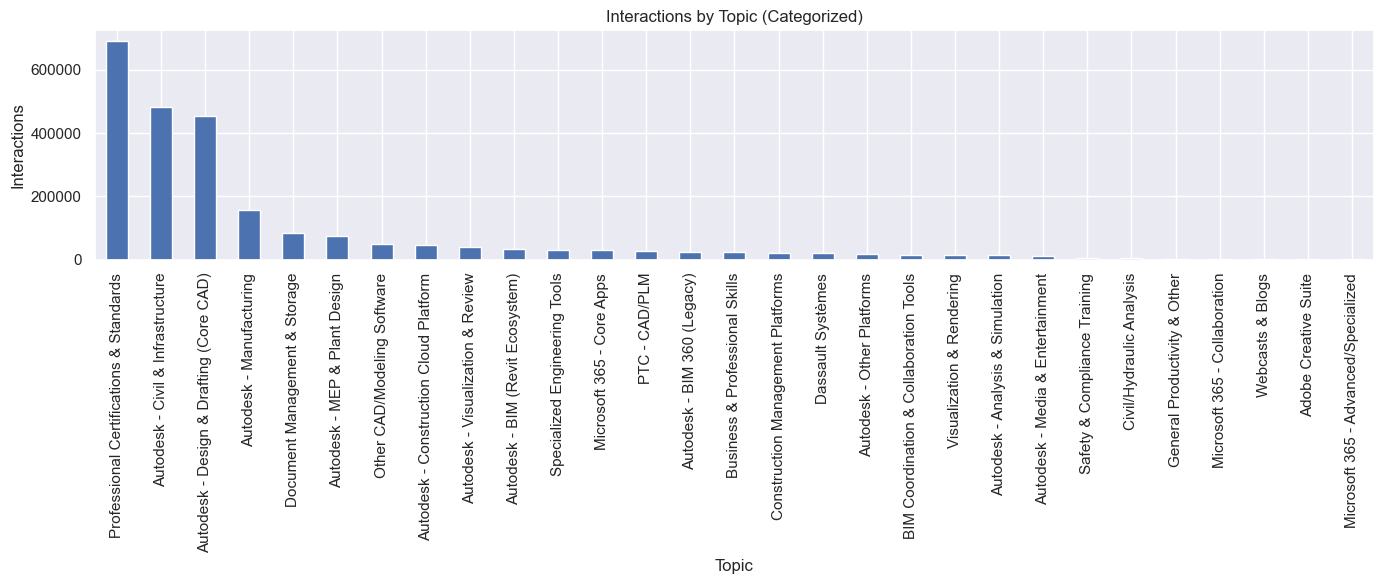

In [7]:
# Bar chart of Interactions by Topic (Categorized)
fig, ax = plt.subplots(figsize=(14, 6))
topic_data = interactions_agg_long.groupby('CATEGORY')['INTERACTION_ID'].nunique().sort_values(ascending=False)
topic_data.plot(kind='bar', ax=ax)
ax.set_xlabel('Topic')
ax.set_ylabel('Interactions')
ax.set_title('Interactions by Topic (Categorized)')
plt.tight_layout()
plt.show()

This looks much better. It's notable to see Professional Certifications as the leader. I would have assumed that anything Autodesk related would have been at the top. I will dive into this further by seeing if any specific industry or segment is responsible for this. 

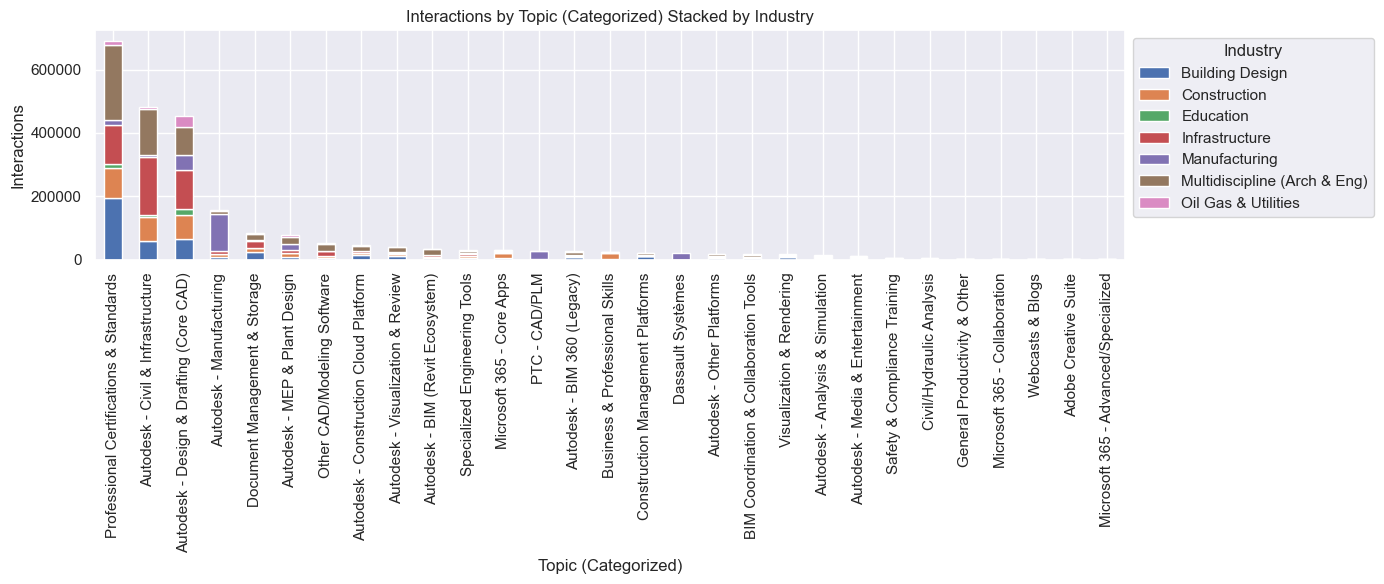

In [8]:
# Bar chart of Interactinos by Topic (Categorized) Stacked by Industry
fig, ax = plt.subplots(figsize=(14, 6))
stacked_data = interactions_agg_long.groupby(['CATEGORY', 'INDUSTRY'])['INTERACTION_ID'].nunique().unstack(fill_value=0)
stacked_data = stacked_data.loc[stacked_data.sum(axis=1).sort_values(ascending=False).index]
stacked_data.plot(kind='bar', stacked=True, ax=ax, figsize=(14, 6))
ax.set_xlabel('Topic (Categorized)')
ax.set_ylabel('Interactions')
ax.set_title('Interactions by Topic (Categorized) Stacked by Industry')
ax.legend(title='Industry', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

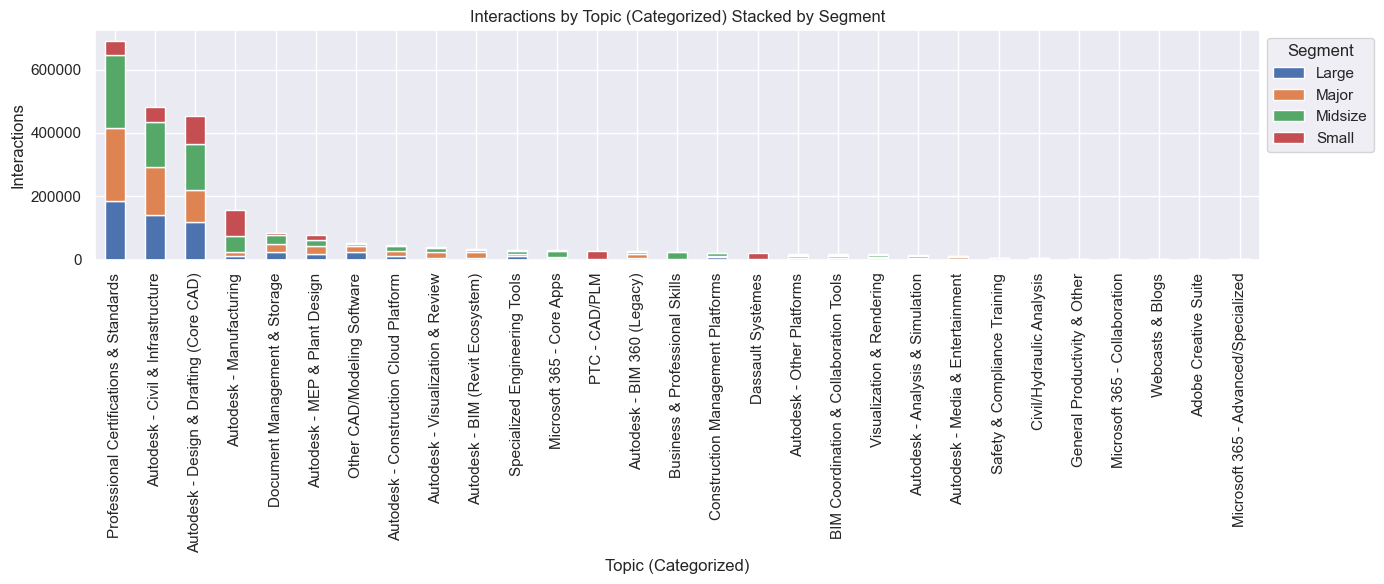

In [9]:
# Bar chart of Interactions by Topic (Categorized) Stacked by Segment
fig, ax = plt.subplots(figsize=(14, 6))
stacked_data = interactions_agg_long.groupby(['CATEGORY', 'SEGMENT'])['INTERACTION_ID'].nunique().unstack(fill_value=0)
stacked_data = stacked_data.loc[stacked_data.sum(axis=1).sort_values(ascending=False).index]
stacked_data.plot(kind='bar', stacked=True, ax=ax, figsize=(14, 6))
ax.set_xlabel('Topic (Categorized)')
ax.set_ylabel('Interactions')
ax.set_title('Interactions by Topic (Categorized) Stacked by Segment')
ax.legend(title='Segment', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

For both industry and segment, this is what I was hoping to see. My concern was tha there was a customer or two who might be accounting for most of the professional certificate content consumption. However, since there is mostly equal distribution here between the attributes, then I don't think this is a legitimate concern, and is a true representation of the data. I will now investigate the specific shares of the data that each attribute has (industry and segment).

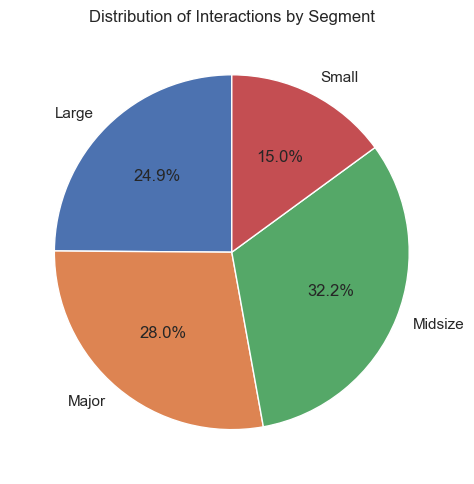

In [10]:
# Pie chart of Interactions by Segment
fig, ax = plt.subplots(figsize=(5, 5))
segment_data = interactions_agg_long.groupby('SEGMENT')['INTERACTION_ID'].nunique()
ax.pie(segment_data, labels=segment_data.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Interactions by Segment')
plt.tight_layout()
plt.show()

This is actually a much more equal split than I anticipated.

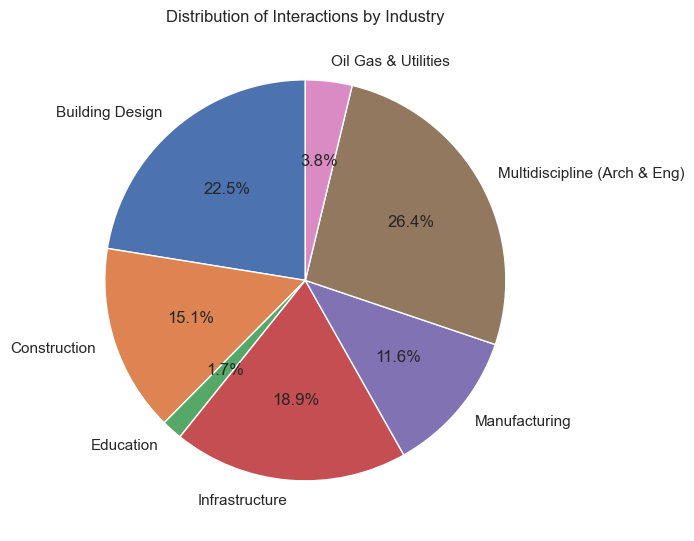

In [11]:
# Pie chart of Interactions by Industry
fig, ax = plt.subplots(figsize=(7, 7))
segment_data = interactions_agg_long.groupby('INDUSTRY')['INTERACTION_ID'].nunique()
ax.pie(segment_data, labels=segment_data.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Interactions by Industry')
plt.tight_layout()
plt.show()

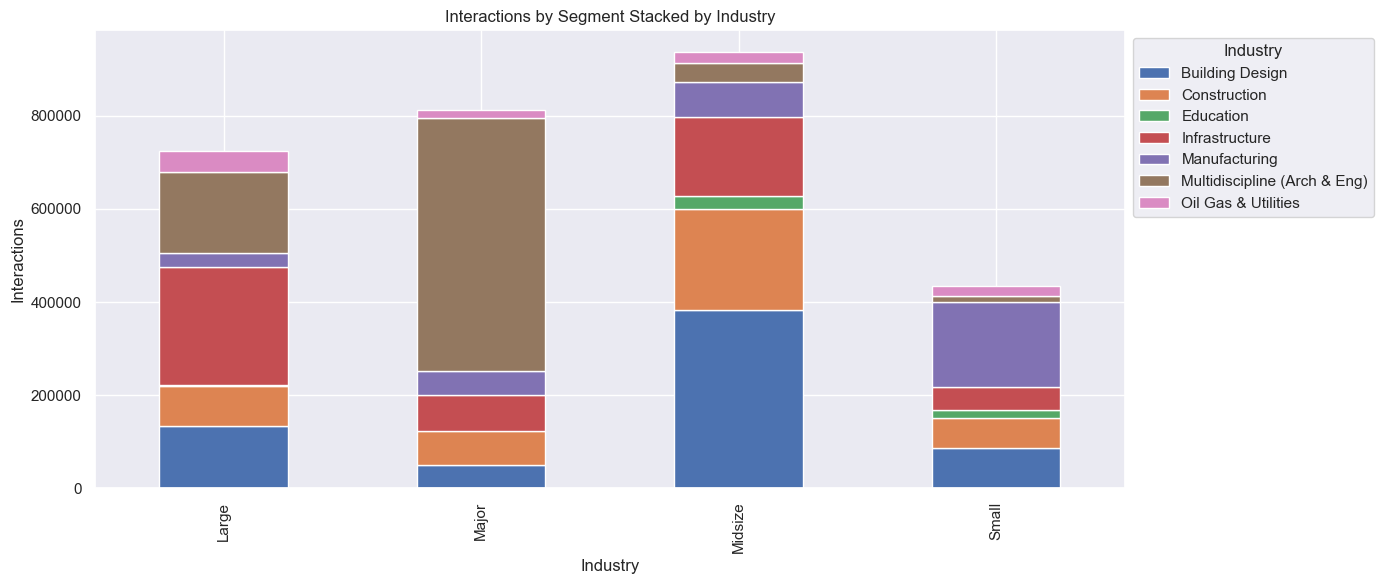

In [12]:
# Bar chart of Interactions by Segment Stacked by Industry
fig, ax = plt.subplots(figsize=(14, 6))
industry_data = interactions_agg_long.groupby(['SEGMENT', 'INDUSTRY'])['INTERACTION_ID'].nunique().reset_index()
industry_pivot = industry_data.pivot(index='SEGMENT', columns='INDUSTRY', values='INTERACTION_ID').fillna(0)
industry_pivot.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Industry')
ax.set_ylabel('Interactions')
ax.set_title('Interactions by Segment Stacked by Industry')
ax.legend(title='Industry', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

The data is mostly evenly split by segment. This is suprising to me as I would have thought that the small segment would be almost trumped entirely by large and major usage. Our industries have a few unbalanced classes, but this is to be expected. We don't go out of our way to do business in the education sector or in the Utilities sector. Manufacturing would be out next weakest link, but is something we are wanting to grow into. When looking at the industry spread within each segment, its very intersting to see manufacturing taking up most of the small segment, midsize containing mostly building design, and major containing mostly multidiscipline customers. I don't foresee this being an issue for the model development, but this is an interesting business insight for us to talk about. I will now look to see if we can spot trends in the topic usage over time.

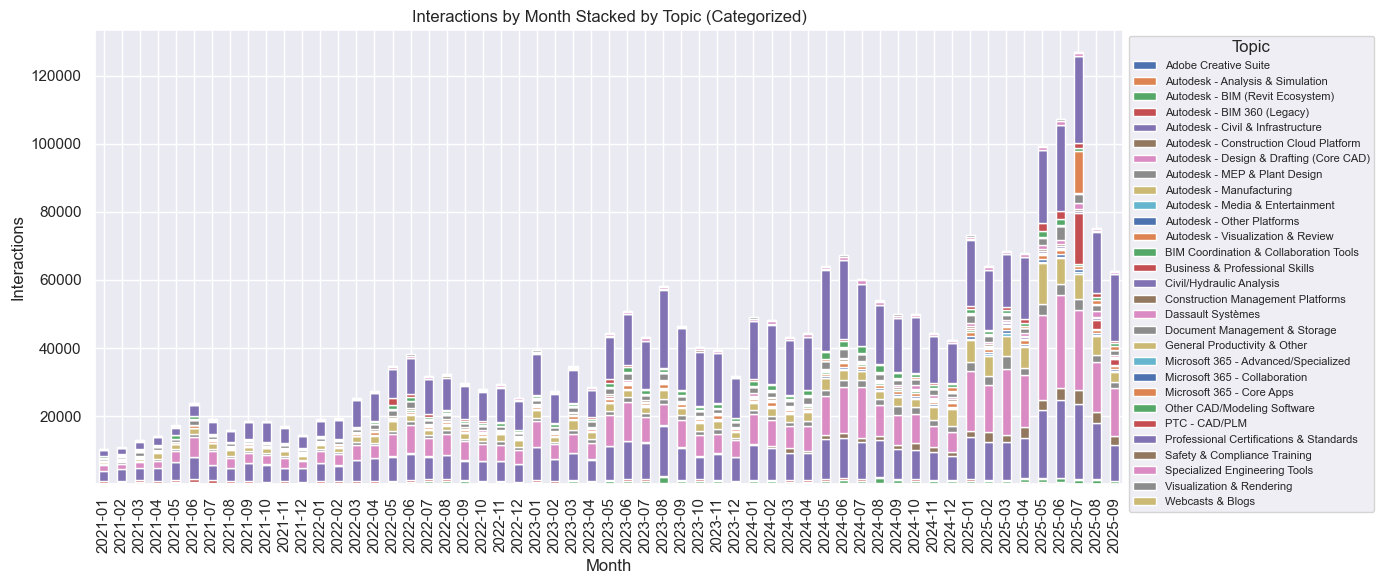

In [13]:
# Convert interaction date to datetime
interactions_agg_long['INTERACTION_DATE'] = pd.to_datetime(interactions_agg_long['INTERACTION_DATE'])
interactions_agg_long['MONTH'] = interactions_agg_long['INTERACTION_DATE'].dt.to_period('M').astype(str)

# Bar chart of Interactions by Month Stacked by Topic (Categorized)
fig, ax = plt.subplots(figsize=(14, 6))
month_data = interactions_agg_long.groupby(['MONTH', 'CATEGORY'])['INTERACTION_ID'].nunique().reset_index()
month_pivot = month_data.pivot(index='MONTH', columns='CATEGORY', values='INTERACTION_ID').fillna(0)
month_pivot.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Interactions')
ax.set_title('Interactions by Month Stacked by Topic (Categorized)')
ax.legend(title='Topic', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

There doesn't appear to be anything out of the ordinary going on here. The growth in usage of each topic looks healthy and evenly distributed over time, so there shouldn't need to be a concern about outliers or certain influences at different points in history.

Now let's create a social network analysis to see if we can spot relationships among how different users are consuming different topics. This will be useful to provide leadership so that they can get a visual understanding of how consumptino patterns are linked, as this is not something a black box algorithm can provide us. While the results of each might not match up, the network analysis will give us a generalization of what to expect.

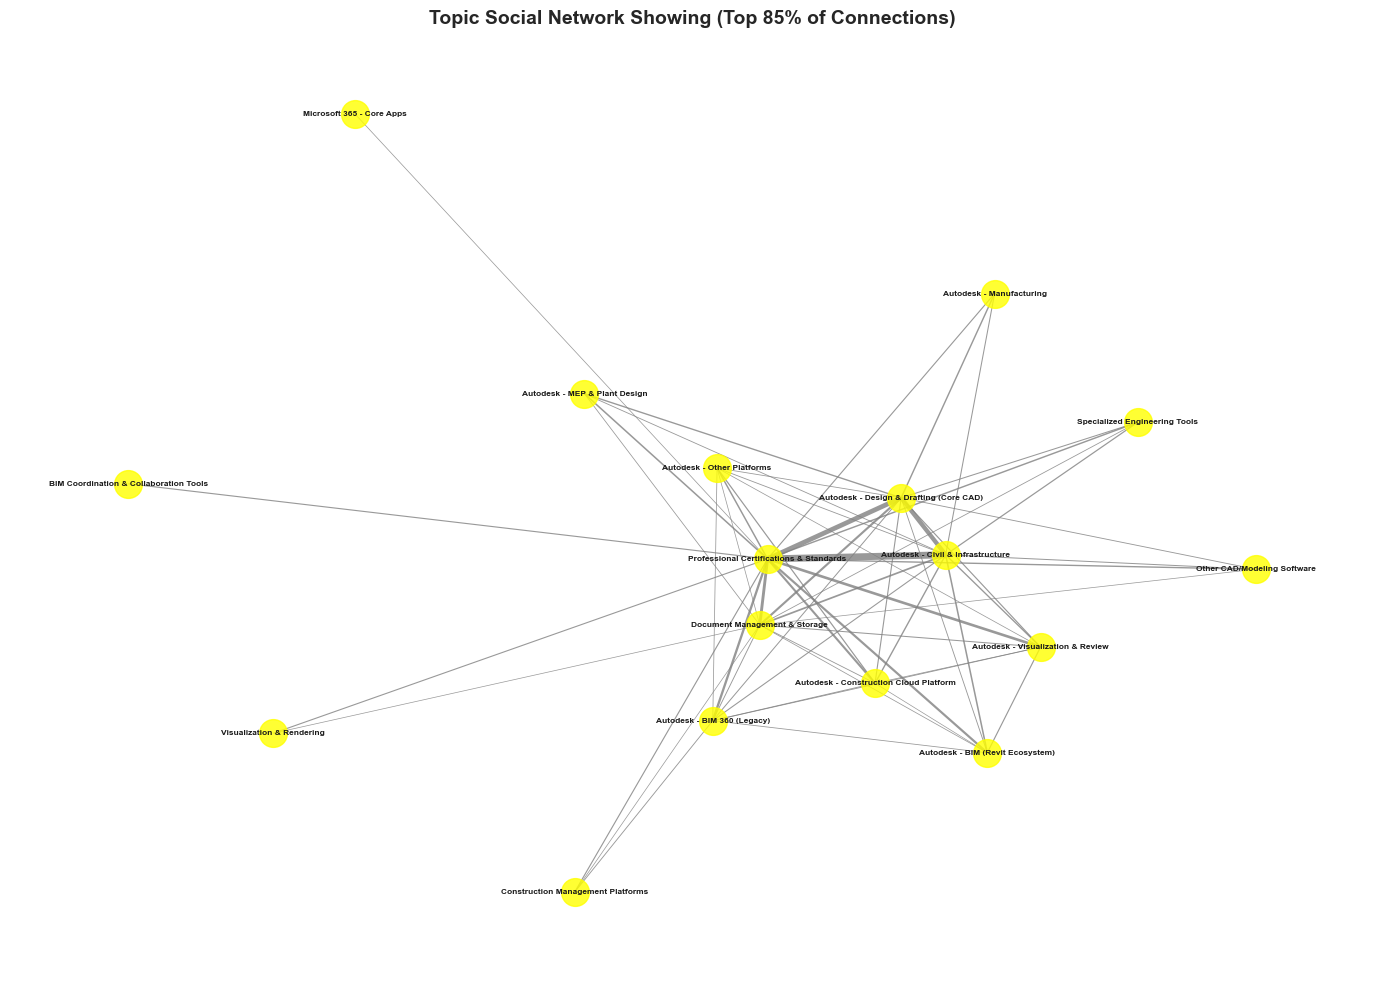

In [20]:
# Source
# DataCamp: https://www.datacamp.com/tutorial/social-network-analysis-python (I also have a subscription through work and took a course on this)
# Networkx: https://networkx.org/documentation/stable/tutorial.html
# Networkx: https://networkx.org/documentation/stable/auto_examples/drawing/plot_weighted_graph.html

# Set the grouping val and the threshold percentage
grouping_val = 'USER_ID'
percent_thresh = 85 # This will remove the botton n percentage of weights
node_color = 'yellow'
graph_title = f"Topic Social Network Showing (Top {percent_thresh}% of Connections)"

# Group by user to find which topics (categorized) each user interacted with
user_topics = interactions_agg_long.groupby(grouping_val)['CATEGORY'].apply(list).reset_index()
#user_topics = (interactions_agg_long[interactions_agg_long['SEGMENT'] == 'Small'].groupby(grouping_val)['CATEGORY'].apply(list).reset_index())
#user_topics = (interactions_agg_long[interactions_agg_long['INDUSTRY'] == 'Building Design'].groupby(grouping_val)['CATEGORY'].apply(list).reset_index())

# Build edges between topics that were consumed by the same user
edge_weights = {}
for topics in user_topics['CATEGORY']:
    # Grab unique topics for each user
    unique_topics = list(set([t for t in topics if isinstance(t, str)])) # Disclaimer: Claude helped me build this line. I was having type errors, so Claude help me build the isinstance check.
    
    # Source 1: https://stackoverflow.com/questions/464864/how-to-get-all-possible-2n-combinations-of-a-list-s-elements-of-any-length
    # Source 2 - itertools: https://docs.python.org/3/library/itertools.html
    if len(unique_topics) > 1:
        for topic1, topic2 in combinations(unique_topics, 2):
            edge = tuple(sorted([topic1, topic2]))
            edge_weights[edge] = edge_weights.get(edge, 0) + 1

# Filter to top x% of connections by weight - Source: https://numpy.org/doc/2.3/reference/generated/numpy.percentile.html
weight_threshold = np.percentile(list(edge_weights.values()), percent_thresh)

# Create graph with only top x% of edges
G = nx.Graph()
for (topic1, topic2), weight in edge_weights.items():
    if weight >= weight_threshold:
        G.add_edge(topic1, topic2, weight=weight)

# Remove nodes with no connections
G.remove_nodes_from(list(nx.isolates(G)))

# Visualization
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=2, iterations=50, seed=42) # Layout
nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=400, alpha=0.8) # Nodes
# Disclaimer: Claude helped me with the next 3 lines. I couldn't find solid documentation about normalizing the edge thicknesses.
edges = G.edges() # Grab nodes from edges
weights = [G[n1][n2]['weight'] for n1, n2 in edges] # Grab weights from node combos
edge_widths = [0.5 + 4.5 * (w - min(weights)) / (max(weights) - min(weights)) for w in weights] # Normalize weights for edge thickness (min=0.5, max=5)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.8, edge_color='gray') # Edges
nx.draw_networkx_labels(G, pos, font_size=6, font_weight='bold') # Labels
plt.title(graph_title, fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


I will still try and train the models using the normal TOPIC or TOPIC_SUBTOPIC values. If performance does not shape up well, I will attempt with the 'Categorized' column. Hopefully the 'deep learning' element of this will allow us to use the granular attributes. 

I will now conduct PCA on the KNN dataset to see if there is any consolidation we can be doing to topics for better model performance.

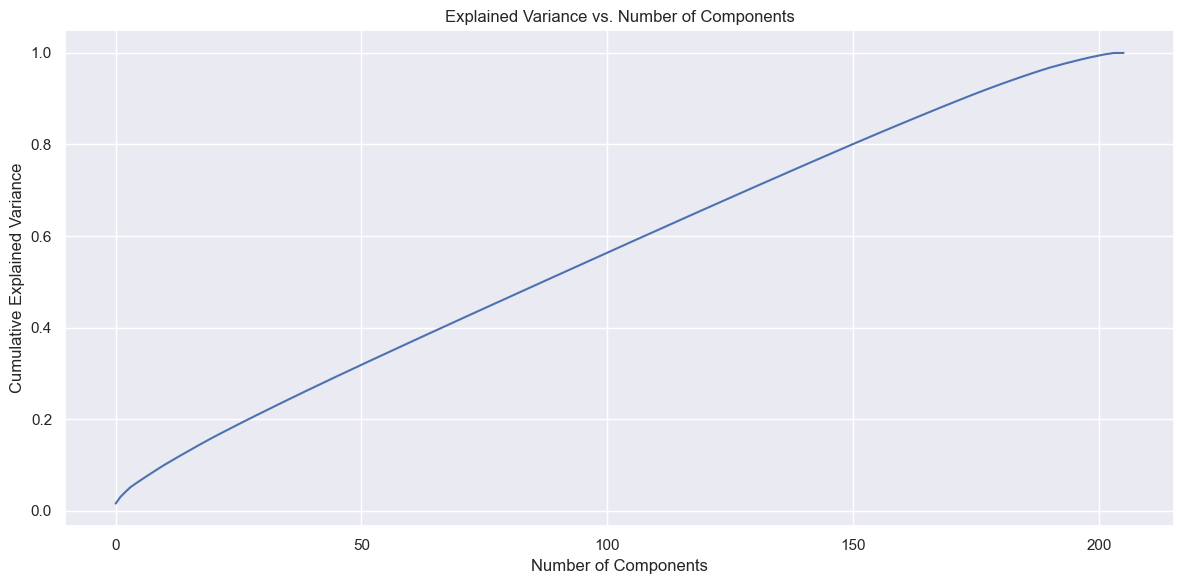

In [15]:
# sklearn docs: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# DataCamp: https://www.datacamp.com/tutorial/principal-component-analysis-in-python

# Copy data
df = knn_dataset.copy()

# All the topic/content columns (the Float columns)
feature_columns = [col for col in df.columns if col not in ['USER_ID', 'TENANT_ID', 'INDUSTRY', 'SEGMENT', 'INDUSTRY_encoded', 'SEGMENT_encoded']]

# Extract feature matrix
X = df[feature_columns].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained Variance Ratio
plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.tight_layout()
plt.show()


Conducting PCA shows that the topic variables are mostly independent of each other. The cumulative explained variance versus number of components is almost perfectly linear, which indicates that there isn't much value in reducing the variables. Specifically, 188 of the 208 components (90%) are needed to capture 95% of the variance, representing only a 10% dimensionality reduction. As a result, PCA will 
not be used to reduce the variables for the final KNN model. If model performance is not suitable or training time takes too long, I will consider using the categorized version of topics instead.